# DistilBERT French: Experiments across modality, time and country

**Outline:**  
Experiment 1: DistilBERT French (training on data from Manifesto Project)      
Experiment 2: Across time (evaluation on data > 2018)  
Experiment 3: Across country (evaluation per country)  

# Experiment 1: 
**Training data:** data version from Manifest project (version 2018-2)   
**Testing data:** random test split    
**Models:** flaubert-small-cased
**Result:** 



## Loading the packages, functions and dataset

In [ ]:
# save results in...
path_results = './drive/MyDrive/Paper BERT/results/03_DistilBERT French/2022-04-15'

In [ ]:
# Load google drive. 
# Note: Working directory might need to be changed if run on your computer.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.1 MB/s eta 0:00:00


In [ ]:
# for flaubert
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=4ad2269f019ef003f4434a70565b273c5fe198ea628cfe596f639e4c7e15beac
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses


In [ ]:
# set wroking directory
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Paper BERT/notebooks')
from BERT_utils import *

In [ ]:
# set seeds for reproducibility
transformers.set_seed(3)
transformers.enable_full_determinism(3)
np.random.seed(3)

In [ ]:
# load data
path_file = './drive/MyDrive/Paper BERT/data/multilingual_data_2018-2.csv'
data = pd.read_csv(path_file,  index_col=None)

# ensure variables as string
data['topic_8'] = data['topic_8'].astype(str) # categories
data['text'] = data['text'].astype(str) # topic

Select only French as language:

In [ ]:
# select only French observations
data_french = data.loc[data['language'] =="french", :]
print(data_french.shape)
print(data_french['countryname'].unique())
data_french.head(3) 
# note: English 114,523 observations

(22357, 7)
['Luxembourg' 'France' 'Switzerland' 'Canada']


,countryname,text,language,code,document_index,date,topic_8
199507,Luxembourg,DÉI GRÉNG présentent dans les pages qui vienne...,french,0.0,1,200406,no topic
199508,Luxembourg,"Avec courage et responsabilité, avec des idées...",french,305.0,1,200406,political system
199509,Luxembourg,Le slogan de la campagne électorale des Verts ...,french,305.0,1,200406,political system


## Train-Test-Validation data sets

In [ ]:
# X: text, Y: topic
X = data_french['text'] 
Y = data_french['topic_8']

# Y numeric
Y_numeric = pd.factorize(Y)[0]
classes = pd.factorize(Y)[1]

# mapping: numeric -> category
dic_y_mapping = {n:label for n,label in enumerate(classes)}

# reverese mapping: catgory -> numeric
dic_y_mapping_inverse = dict(map(reversed, dic_y_mapping.items()))
dic_y_mapping_inverse

# test-train-validation split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_numeric, train_size=.8, random_state=77)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, train_size=0.5, random_state=77)

# overview splits
print('X', X.shape)
print('X_train', X_train.shape, round(X_train.shape[0]/X.shape[0], 2))
print('X_test', X_test.shape, round(X_test.shape[0]/X.shape[0], 2))
print('X_val', X_val.shape, round(X_val.shape[0]/X.shape[0], 2))

X (22357,)
X_train (17885,) 0.8
X_test (2236,) 0.1
X_val (2236,) 0.1


In [ ]:
# create same split for country variable for evaluation per country
country = data_french['countryname']
X_train, X_test, country_train , country_test  = train_test_split(X, country, train_size=.8, random_state=77)
X_test, X_val, country_test, country_val = train_test_split(X_test, country_test, train_size=0.5, random_state=77)

In [ ]:
# create dataset for training
dataset = {'train':Dataset.from_dict({'label':Y_train,'text':X_train}),
     'validation':Dataset.from_dict({'label':Y_val,'text':X_val}),
     'test':Dataset.from_dict({'label':Y_test,'text':X_test})
     }
dataset = DatasetDict(dataset)

# structure data set
print(dataset)

# example
dataset["train"][0]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 17885
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 2236
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 2236
    })
})


{'label': 3,
 'text': 'Les habitants des communes de Luxembourg et d’Esch n’ont pas d’avantages, bien au contraire:Le coût pour les communes et les prix ont augmenté.'}

## Preprocessing the data

In [ ]:
# Chose model and corresponing tokenize
from transformers import FlaubertModel, FlaubertTokenizer
model_checkpoint = 'flaubert/flaubert_small_cased' 
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
batch_size = 16

In [ ]:
# Encode data set
def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)
# Note truncation=True: input truncated to the maximum length accepted by the model

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset

Map:   0%|          | 0/17885 [00:00<?, ? examples/s]

Map:   0%|          | 0/2236 [00:00<?, ? examples/s]

Map:   0%|          | 0/2236 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 17885
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2236
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2236
    })
})

## Fine-tuning the model

Fine-tuning with huggingface trainer: https://huggingface.co/transformers/v3.0.2/main_classes/trainer.html

In [ ]:
metric = load_metric('f1')
metric_name = "f1"
num_labels = 8
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
model_name = model_checkpoint.split("/")[-1]

<ipython-input-16-47b4617a7a88>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('f1')


Some weights of the model checkpoint at flaubert/flaubert_small_cased were not used when initializing FlaubertForSequenceClassification: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_small_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for p

In [ ]:
args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    seed=0,
    #push_to_hub=True,
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,1.422300,1.209184,0.461831
2,1.250700,1.126846,0.490631
3,1.155800,1.094797,0.494875


TrainOutput(global_step=3354, training_loss=1.3245247446786952, metrics={'train_runtime': 320.9472, 'train_samples_per_second': 167.177, 'train_steps_per_second': 10.45, 'total_flos': 344661801028608.0, 'train_loss': 1.3245247446786952, 'epoch': 3.0})

In [ ]:
# https://www.thepythoncode.com/article/finetuning-bert-using-huggingface-transformers-python
# saving the fine tuned model & tokenizer
model_path = "./drive/MyDrive/Paper BERT/results/model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('./drive/MyDrive/Paper BERT/results/model/tokenizer_config.json',
 './drive/MyDrive/Paper BERT/results/model/special_tokens_map.json',
 './drive/MyDrive/Paper BERT/results/model/vocab.json',
 './drive/MyDrive/Paper BERT/results/model/merges.txt',
 './drive/MyDrive/Paper BERT/results/model/added_tokens.json')

## Evaluation

### Evaluation on training

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["train"])

{'eval_loss': 1.0028786659240723,
 'eval_f1': 0.53625591484442,
 'eval_runtime': 34.3145,
 'eval_samples_per_second': 521.209,
 'eval_steps_per_second': 32.581,
 'epoch': 3.0}

In [ ]:
def predict_BERT(encoded_dataset, dic_y_mapping, Y_train):
  #https://discuss.huggingface.co/t/different-results-predicting-from-trainer-and-model/12922/4
  #https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b
  # Make prediction
  raw_pred, _, _ = trainer.predict(encoded_dataset)

  # Preprocess raw predictions
  Y_pred = np.argmax(raw_pred, axis=1)

  # prediction
  Y_pred = [dic_y_mapping[y_train] for y_train in Y_pred]
  Y_pred = np.array(Y_pred, dtype= 'object')

  # true values
  Y_classes = [dic_y_mapping[y_train] for y_train in Y_train]
  Y_classes = np.array(Y_classes, dtype= 'object')
  return Y_pred, Y_classes


In [ ]:
Y_pred_training, Y_train_classes = predict_BERT(encoded_dataset["train"], dic_y_mapping, Y_train)
evaluation_training = evaluation_table(Y_train_classes,  Y_pred_training, domain= 'within-domain', data_description ="training")
evaluation_training 

,metric,score,domain,data
0,Accuracy,0.639586,within-domain,training
1,F1 score (macro),0.536256,within-domain,training


### Evaluation on validation data

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["validation"])

{'eval_loss': 1.0947974920272827,
 'eval_f1': 0.49487470832654873,
 'eval_runtime': 4.598,
 'eval_samples_per_second': 486.299,
 'eval_steps_per_second': 30.448,
 'epoch': 3.0}

### Evaluation on test set

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["test"])

{'eval_loss': 1.1054564714431763,
 'eval_f1': 0.515912600033043,
 'eval_runtime': 4.88,
 'eval_samples_per_second': 458.196,
 'eval_steps_per_second': 28.689,
 'epoch': 3.0}

In [ ]:
# get predictions and evaluation metrices
Y_pred_testing, Y_test_classes = predict_BERT(encoded_dataset["test"], dic_y_mapping, Y_test)
evaluation_testing = evaluation_table(Y_test_classes, Y_pred_testing, domain= 'within-domain', data_description ="testing")
evaluation_testing 

,metric,score,domain,data
0,Accuracy,0.608676,within-domain,testing
1,F1 score (macro),0.515913,within-domain,testing


Accuracy: 0.61
Detail:


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,data
economy,0.626984,0.644898,0.635815,490.0,testing
external relations,0.668831,0.691275,0.679868,149.0,testing
fabric of society,0.548387,0.483740,0.514039,246.0,testing
freedom and democracy,0.653333,0.586826,0.618297,167.0,testing
no topic,0.000000,0.000000,0.000000,8.0,testing
political system,0.440678,0.537190,0.484171,242.0,testing
social groups,0.603448,0.450644,0.515971,233.0,testing
welfare and quality of life,0.660377,0.699001,0.679141,701.0,testing


<Figure size 640x480 with 0 Axes>

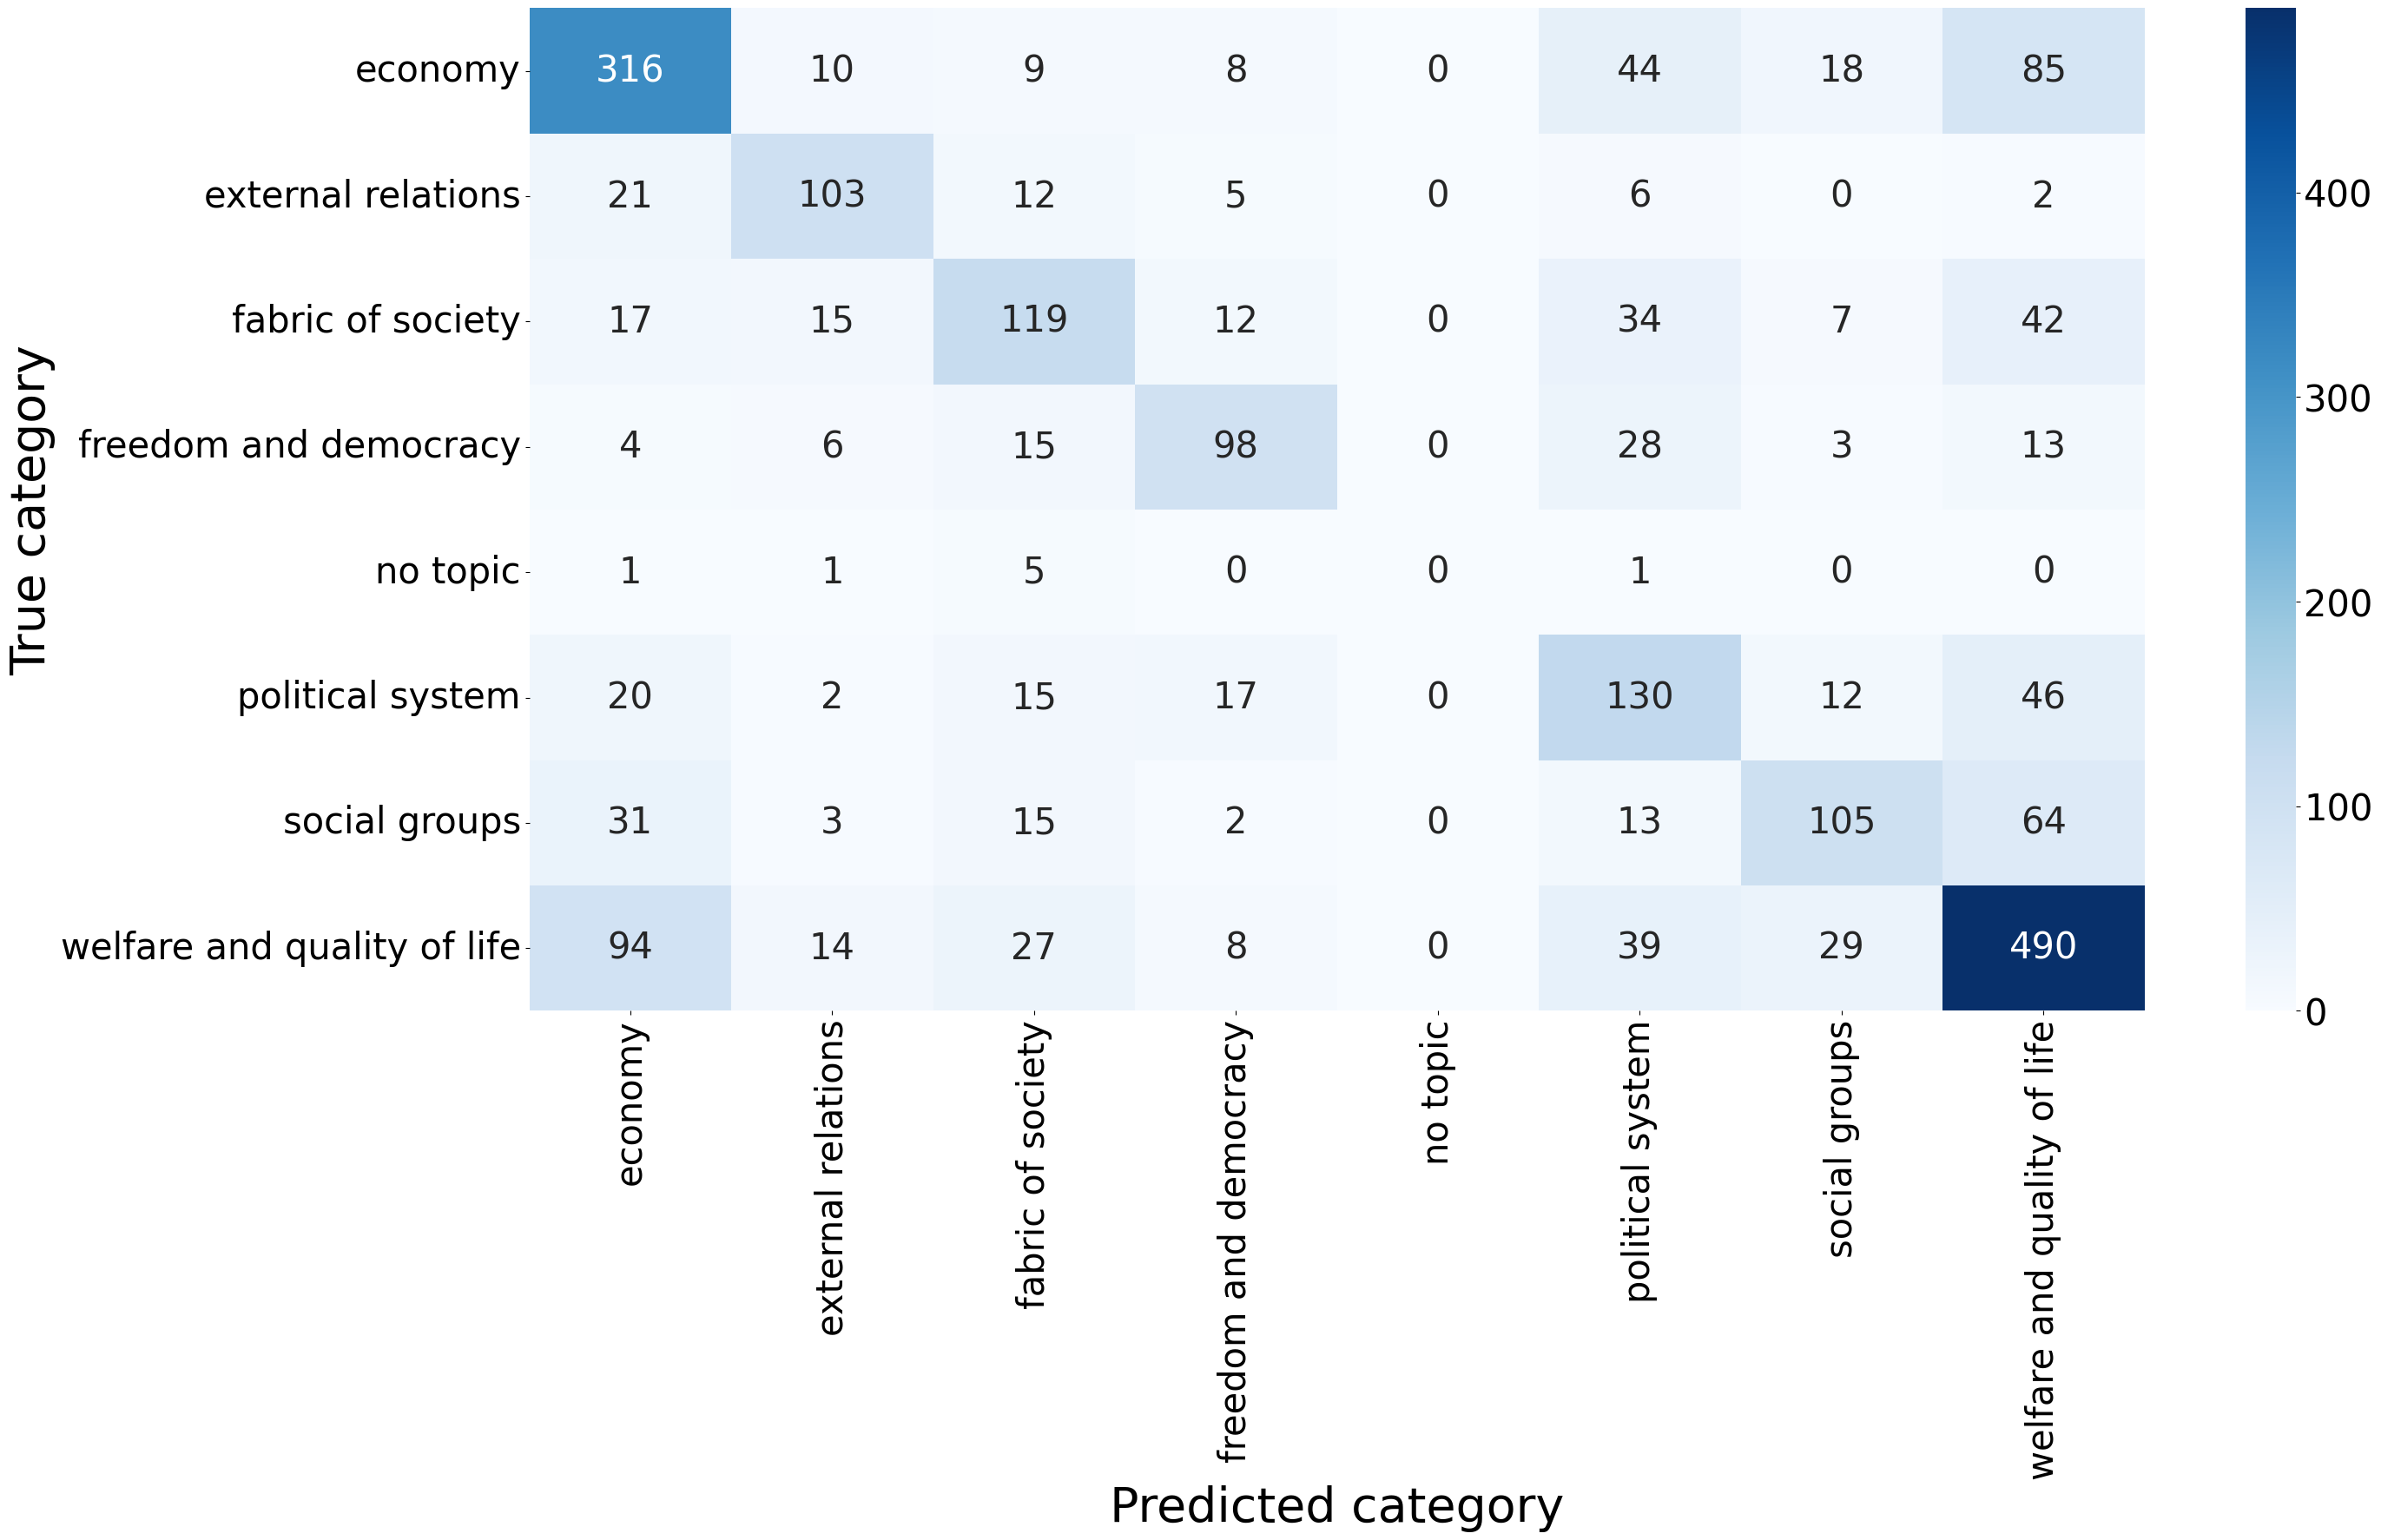

In [ ]:
classification_report_testing = evaluation_per_category(Y_test_classes, Y_pred_testing, data_description ="testing", path_results = path_results, figsize=(30,15))
classification_report_testing

# Experiment 2:
**Model:** fine-tuend DistilBERT (on German data from Manifest project, version 2018-2)   
**Testing data:** data from Manifest project (version 2022-1)   , data > 2018  
**Result:** transfer across time works well 

In [ ]:
# load data
path_file = './drive/MyDrive/Paper BERT/data/multilingual_data_2022-1.csv'
data_2022 = pd.read_csv(path_file,  index_col=None)

# ensure variables as string
data_2022['topic_8'] = data_2022['topic_8'].astype(str) # categories
data_2022['text'] = data_2022['text'].astype(str) # topic

data_2022.head(3)

,countryname,text,language,code,document_index,date,topic_8
0,Sweden,Miljöpartiet de Gröna går till val på en polit...,swedish,408.0,81,200609,economy
1,Sweden,"fler företag,",swedish,402.0,81,200609,economy
2,Sweden,"levande landsbygd,",swedish,301.0,81,200609,political system


In [ ]:
# select french manifestos
data_2022 = data_2022.loc[data_2022['language'] =="french", :]
print(data_2022.shape)
data_2022.head(3) 

(94876, 7)


,countryname,text,language,code,document_index,date,topic_8
160948,Belgium,« Il n’est pas possible de résoudre un problèm...,french,0.0,135,200706,no topic
160949,Belgium,"La raison d’être, la réflexion et les actions ...",french,416.0,135,200706,economy
160950,Belgium,Tel est l’enjeu de la modernisation écologique...,french,416.0,135,200706,economy


In [ ]:
# no data for 2018
print(data_2022[data_2022["date"]==201800].shape)

# number of no topic category observations
print(data_2022[data_2022["topic_8"]=='no topic'].shape)

(0, 7)
(418, 7)


In [ ]:
data_future = data_2022[data_2022["date"]>201800]
print(data_future[data_future["topic_8"]=='no topic'].shape)
print(data_future[data_future["topic_8"]=='political system'].shape)
print(data_future.shape)

X_future = data_future['text'] 
Y_future = data_future['topic_8']

# note: keine "no topics" nor "political system" in data_future

(0, 7)
(0, 7)
(343, 7)


In [ ]:
# creat numeric Y
Y_future_numeric = [dic_y_mapping_inverse[y_test] for y_test in Y_future]
Y_future_numeric = np.array(Y_future_numeric, dtype= 'object')

In [ ]:
# create data set
dataset = {'future':Dataset.from_dict({'label':Y_future_numeric,'text':X_future})}
dataset_future = DatasetDict(dataset)
encoded_dataset_future = dataset_future.map(preprocess_function, batched=True)

Map:   0%|          | 0/343 [00:00<?, ? examples/s]

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset_future["future"])

{'eval_loss': 1.1080530881881714,
 'eval_f1': 0.4782562868635907,
 'eval_runtime': 1.2443,
 'eval_samples_per_second': 275.658,
 'eval_steps_per_second': 17.681,
 'epoch': 3.0}

In [ ]:
Y_pred_future, Y_future_classes = predict_BERT(encoded_dataset_future["future"], dic_y_mapping, Y_future_numeric)

evaluation_future = evaluation_table(Y_future,Y_pred_future, domain= 'cross-domain', data_description ="future")
evaluation_future.to_csv('./drive/MyDrive/Paper BERT/results/evaluation_future.csv')
evaluation_future

,metric,score,domain,data
0,Accuracy,0.609329,cross-domain,future
1,F1 score (macro),0.478256,cross-domain,future


Accuracy: 0.61
Detail:


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

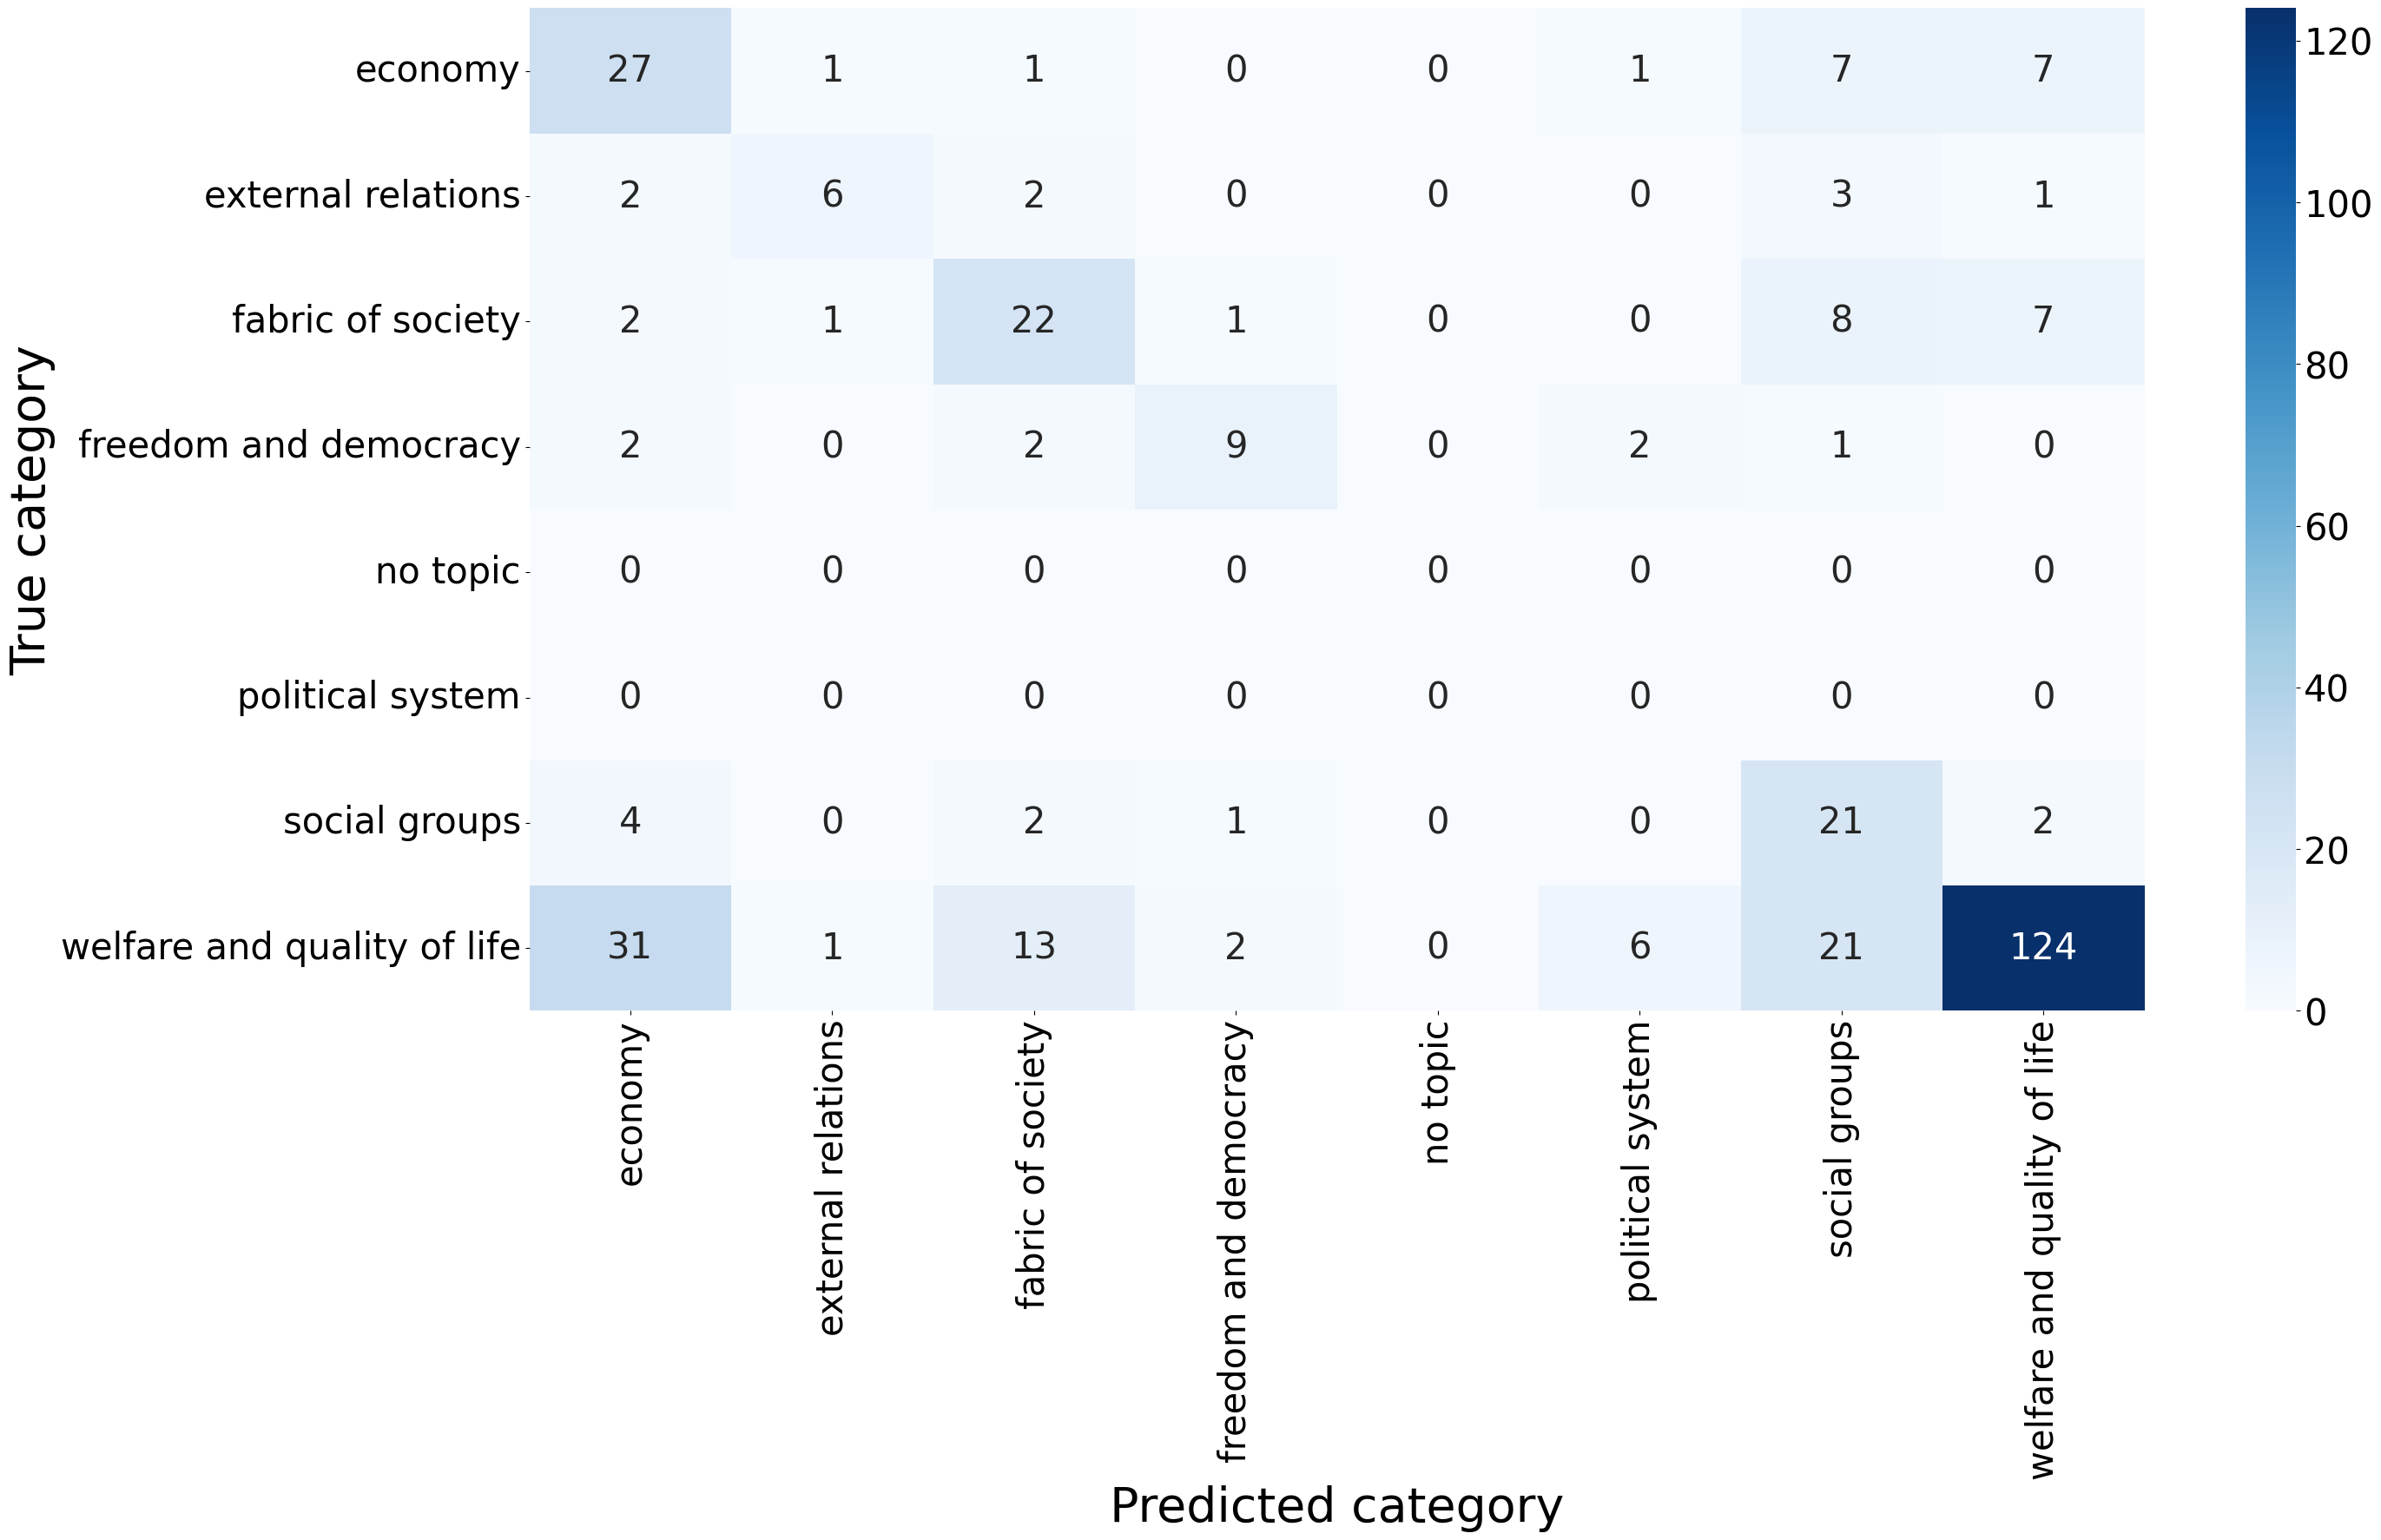

In [ ]:
classification_report_future = evaluation_per_category(Y_future, Y_pred_future, data_description ="future", path_results = path_results, figsize=(30,15)) 

### Overview results Exp 1-3

In [ ]:
eval_metrics = pd.concat([evaluation_training, evaluation_testing, evaluation_future])
eval_metrics.reset_index(drop = True, inplace = True)
eval_metrics.to_csv(path_results + '/eval_metrics.csv')
eval_metrics

,metric,score,domain,data
0,Accuracy,0.639586,within-domain,training
1,F1 score (macro),0.536256,within-domain,training
2,Accuracy,0.608676,within-domain,testing
3,F1 score (macro),0.515913,within-domain,testing
4,Accuracy,0.609329,cross-domain,future
5,F1 score (macro),0.478256,cross-domain,future


In [ ]:
classification_report = pd.concat([classification_report_testing])
classification_report.to_csv(path_results + '/classification_report_' + '.csv', index=True)
classification_report

,precision,recall,f1-score,support,data
economy,0.626984,0.644898,0.635815,490.0,testing
external relations,0.668831,0.691275,0.679868,149.0,testing
fabric of society,0.548387,0.483740,0.514039,246.0,testing
freedom and democracy,0.653333,0.586826,0.618297,167.0,testing
no topic,0.000000,0.000000,0.000000,8.0,testing
political system,0.440678,0.537190,0.484171,242.0,testing
social groups,0.603448,0.450644,0.515971,233.0,testing
welfare and quality of life,0.660377,0.699001,0.679141,701.0,testing


# Expeirment 3: Evaluation per country

In [ ]:
country_eval = pd.DataFrame(index =  ["Accuracy", "F1 macro", "Obsevations", "Number of no topics", "Percentage no topics"])

for i in country.unique():
  country_eval[i] = evaluation_country(i, country_test, Y_test_classes, Y_pred_testing)

country_eval.to_csv(path_results + '/country_eval.csv')
country_eval

,Luxembourg,France,Switzerland,Canada
Accuracy,0.615207,0.625882,0.0,0.570600
F1 macro,0.511544,0.591537,0.0,0.563827
Obsevations,868.000000,850.000000,1.0,517.000000
Number of no topics,8.000000,0.000000,0.0,0.000000
Percentage no topics,0.010000,0.000000,0.0,0.000000


Luxembourg
868
Accuracy: 0.62
Detail:


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


France
850
Accuracy: 0.63
Detail:
Switzerland
1
Accuracy: 0.0
Detail:


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

Canada
517
Accuracy: 0.57
Detail:


<Figure size 640x480 with 0 Axes>

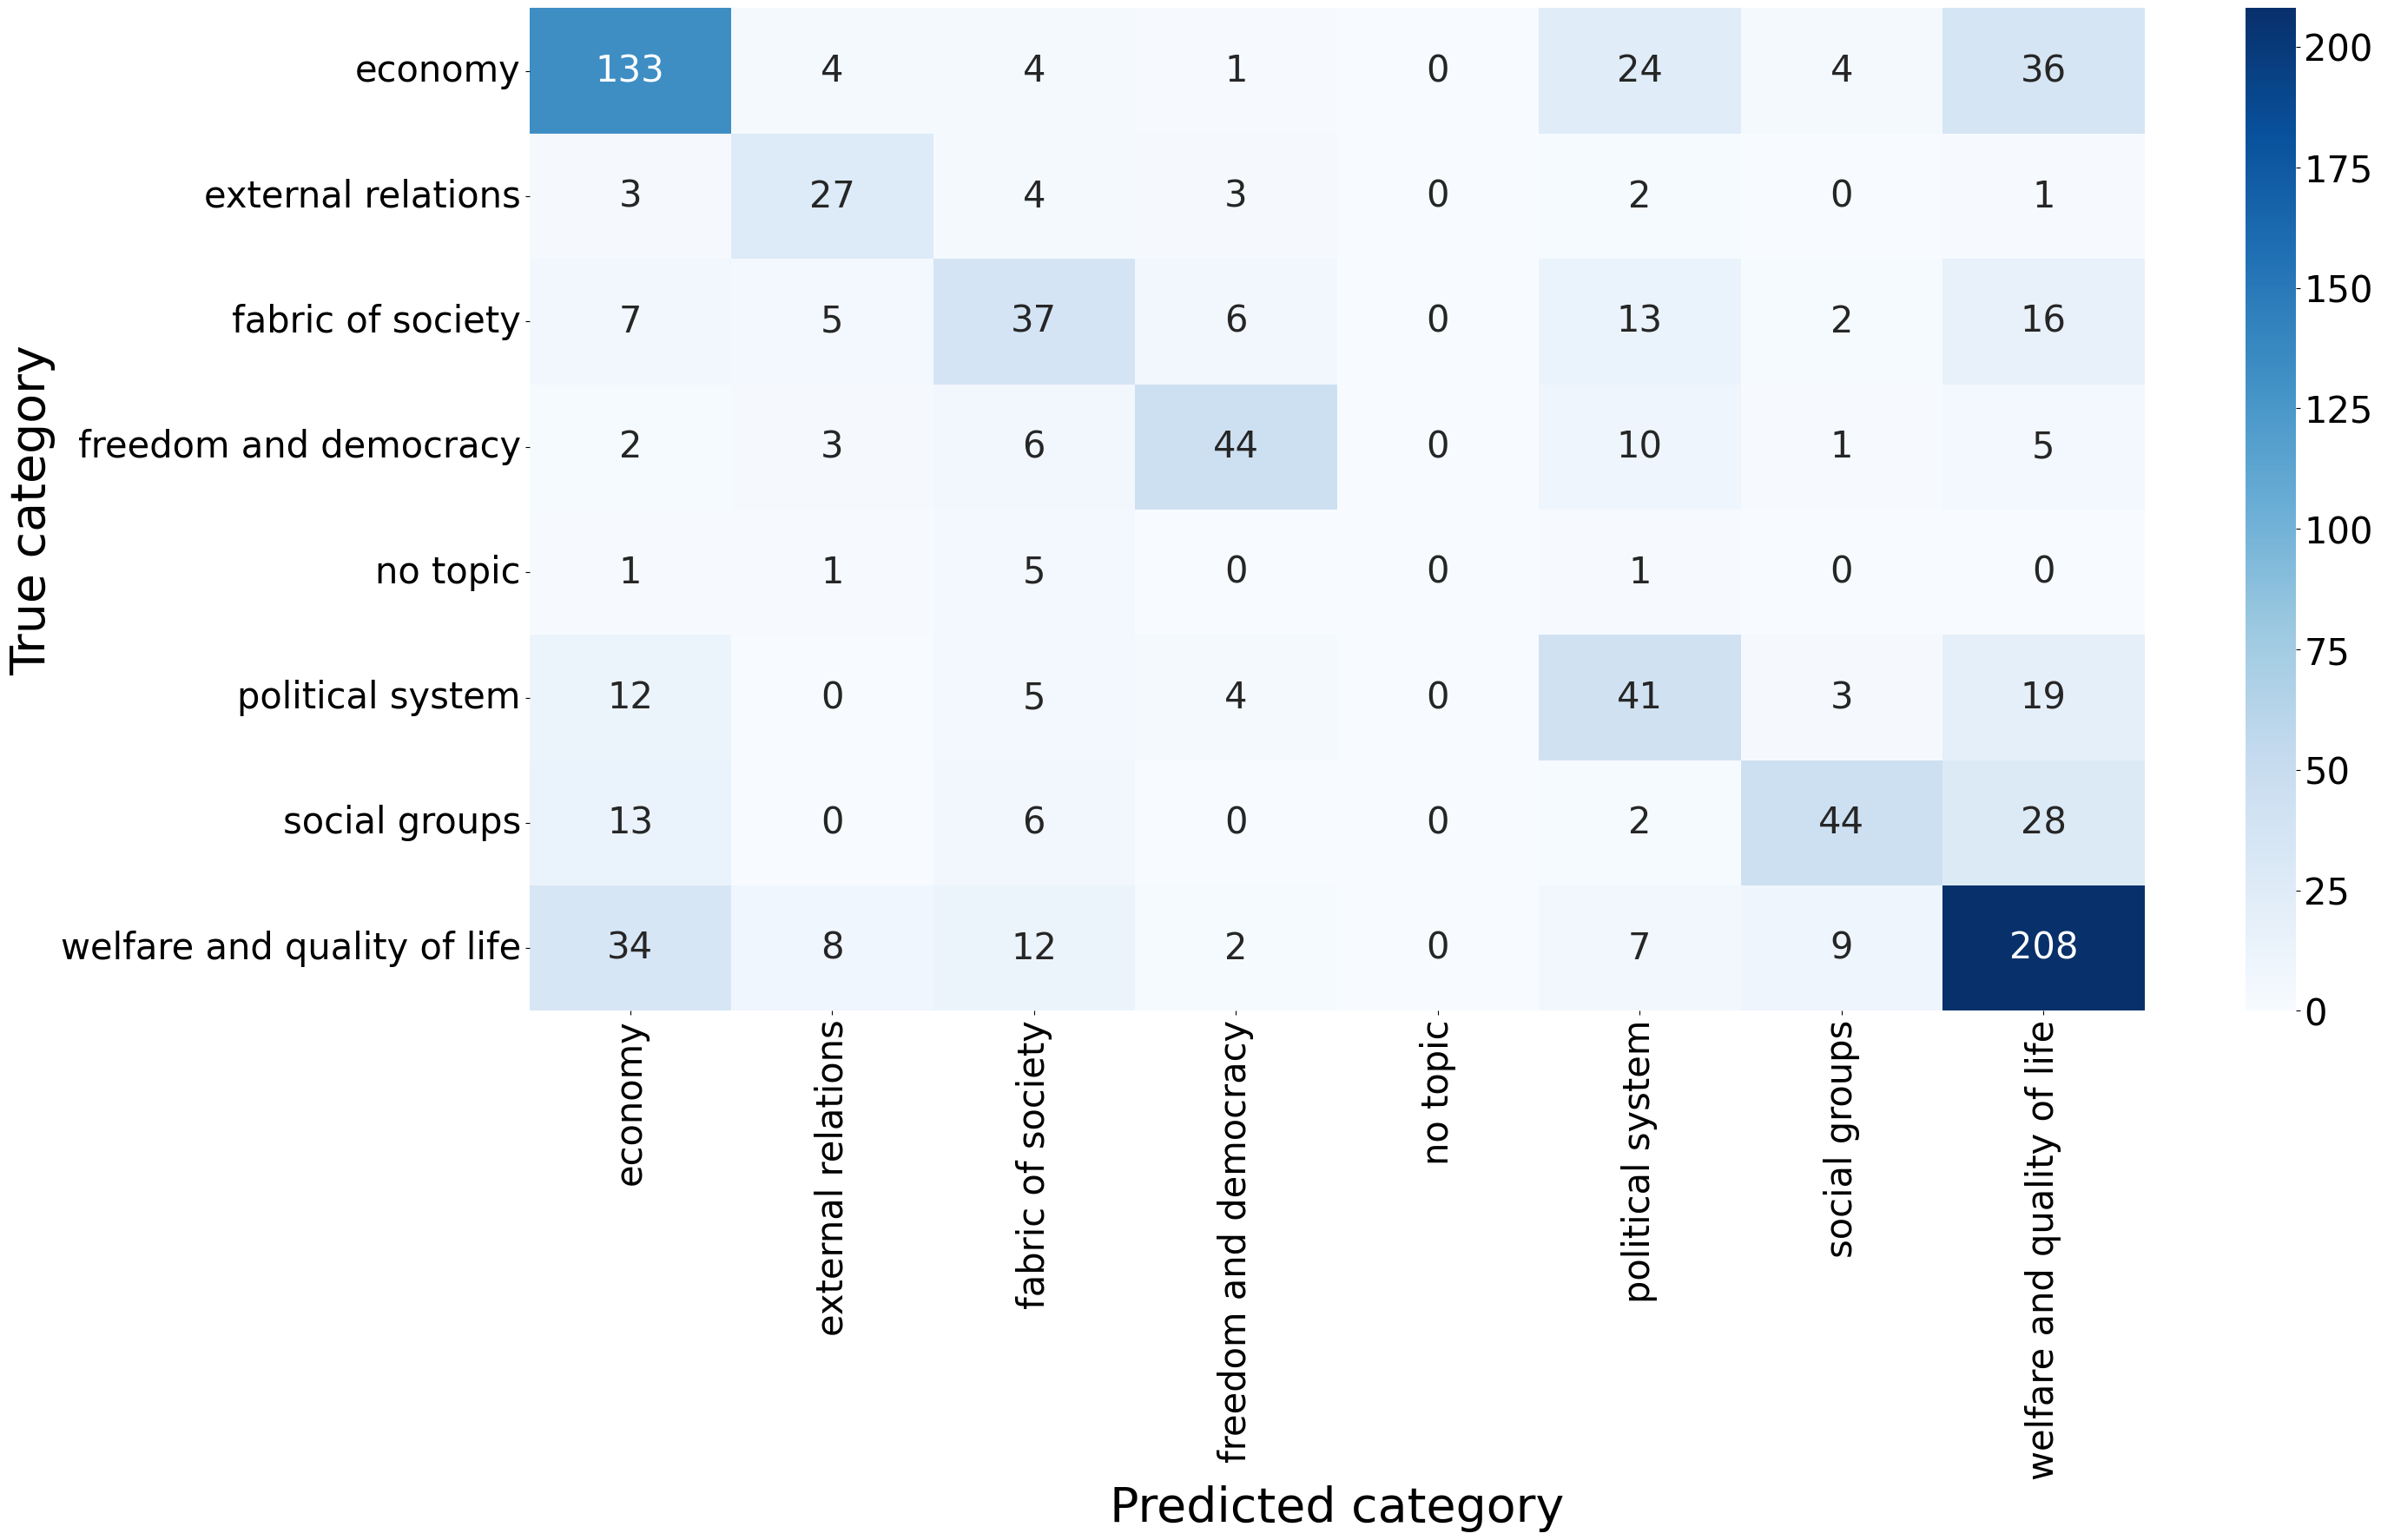

<Figure size 640x480 with 0 Axes>

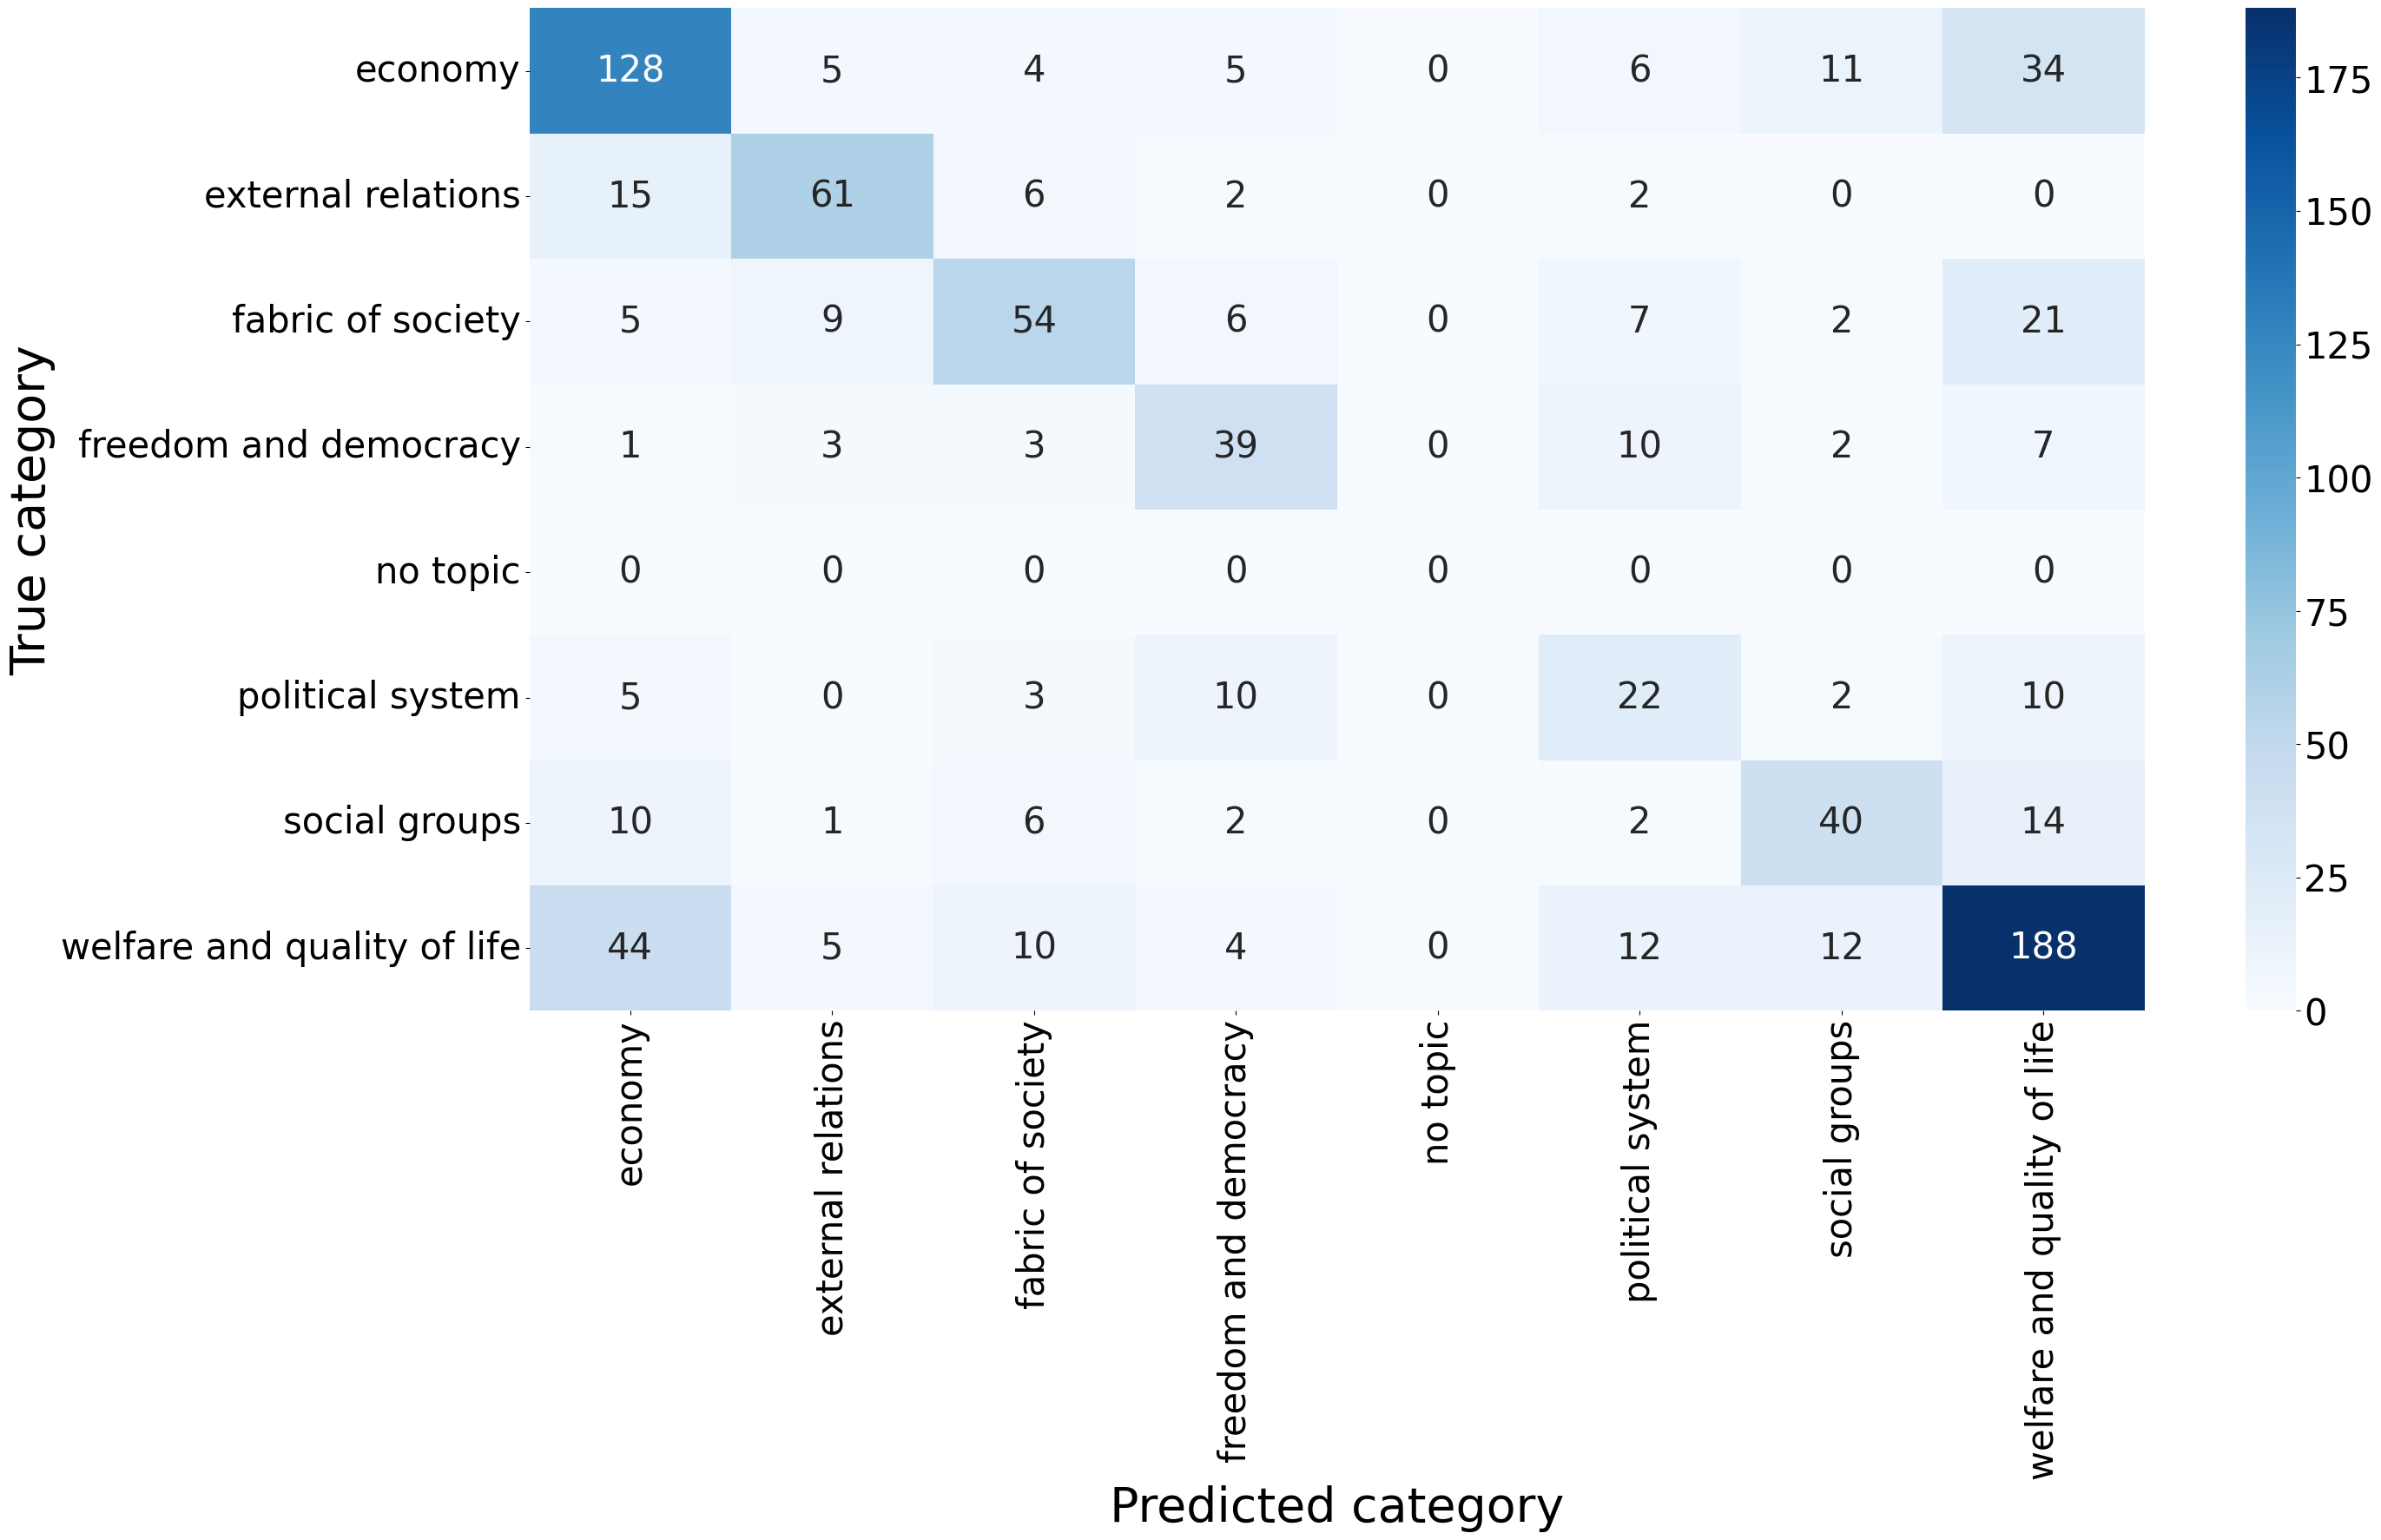

<Figure size 640x480 with 0 Axes>

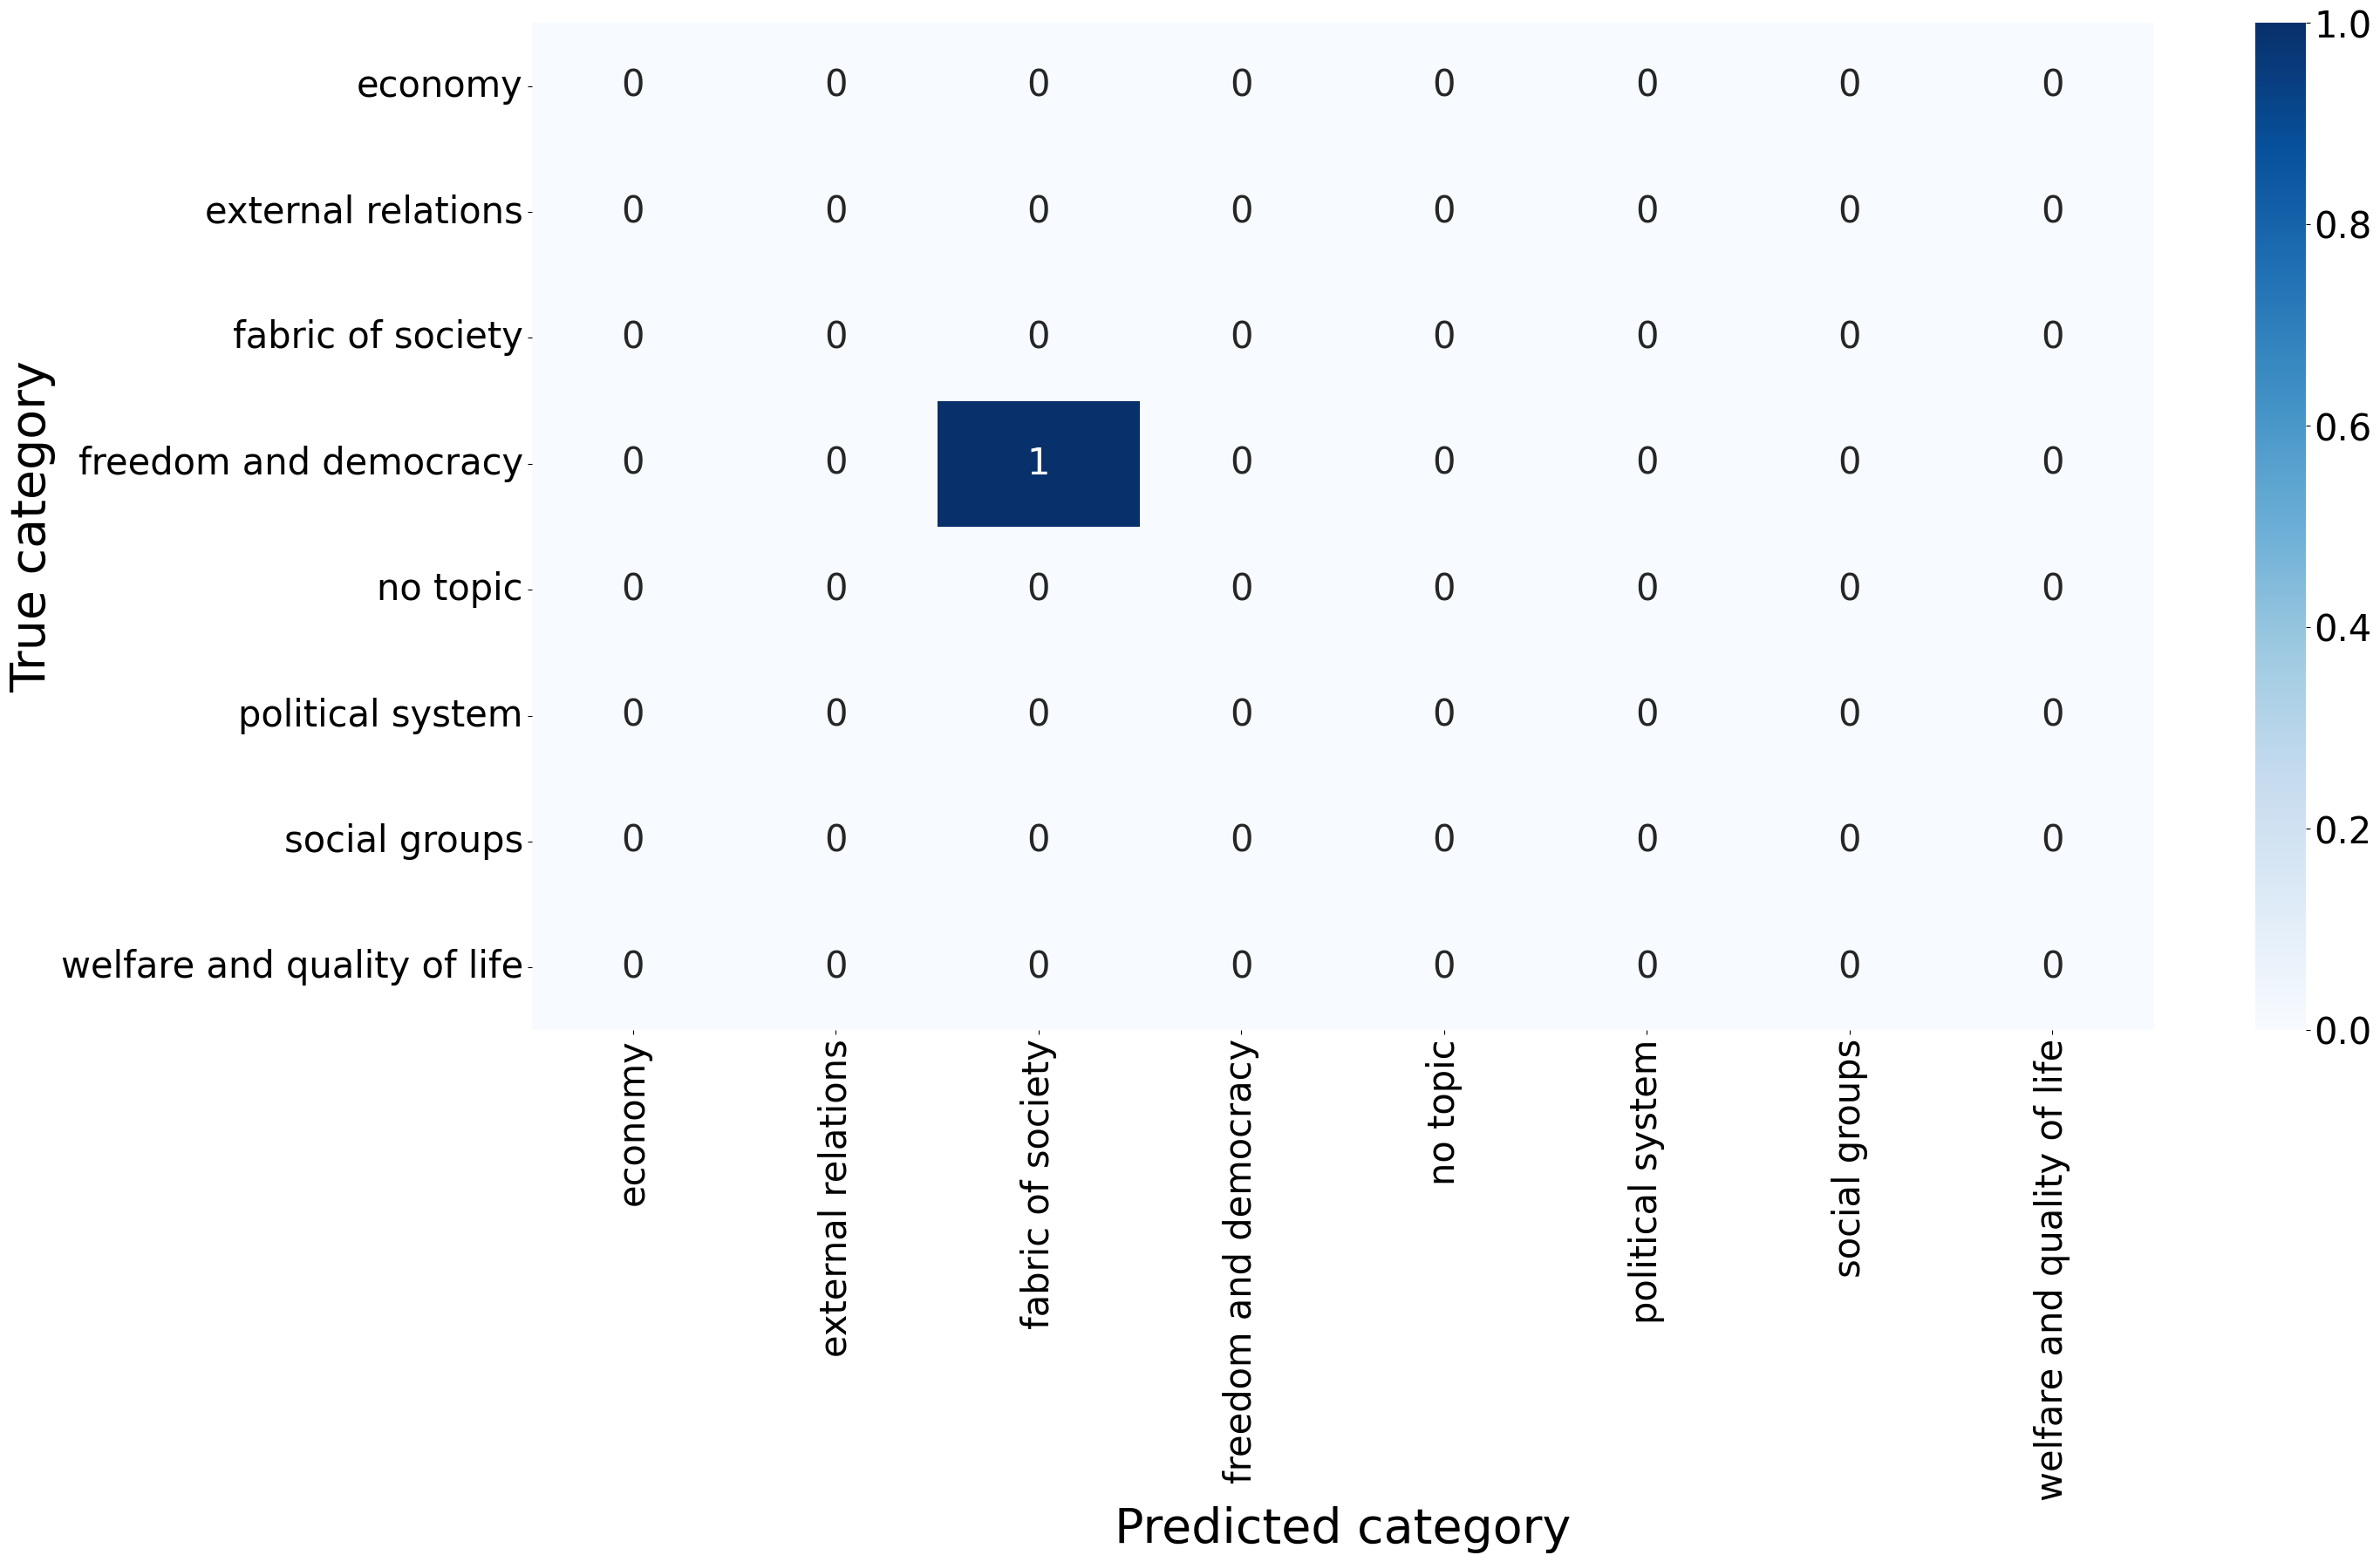

<Figure size 640x480 with 0 Axes>

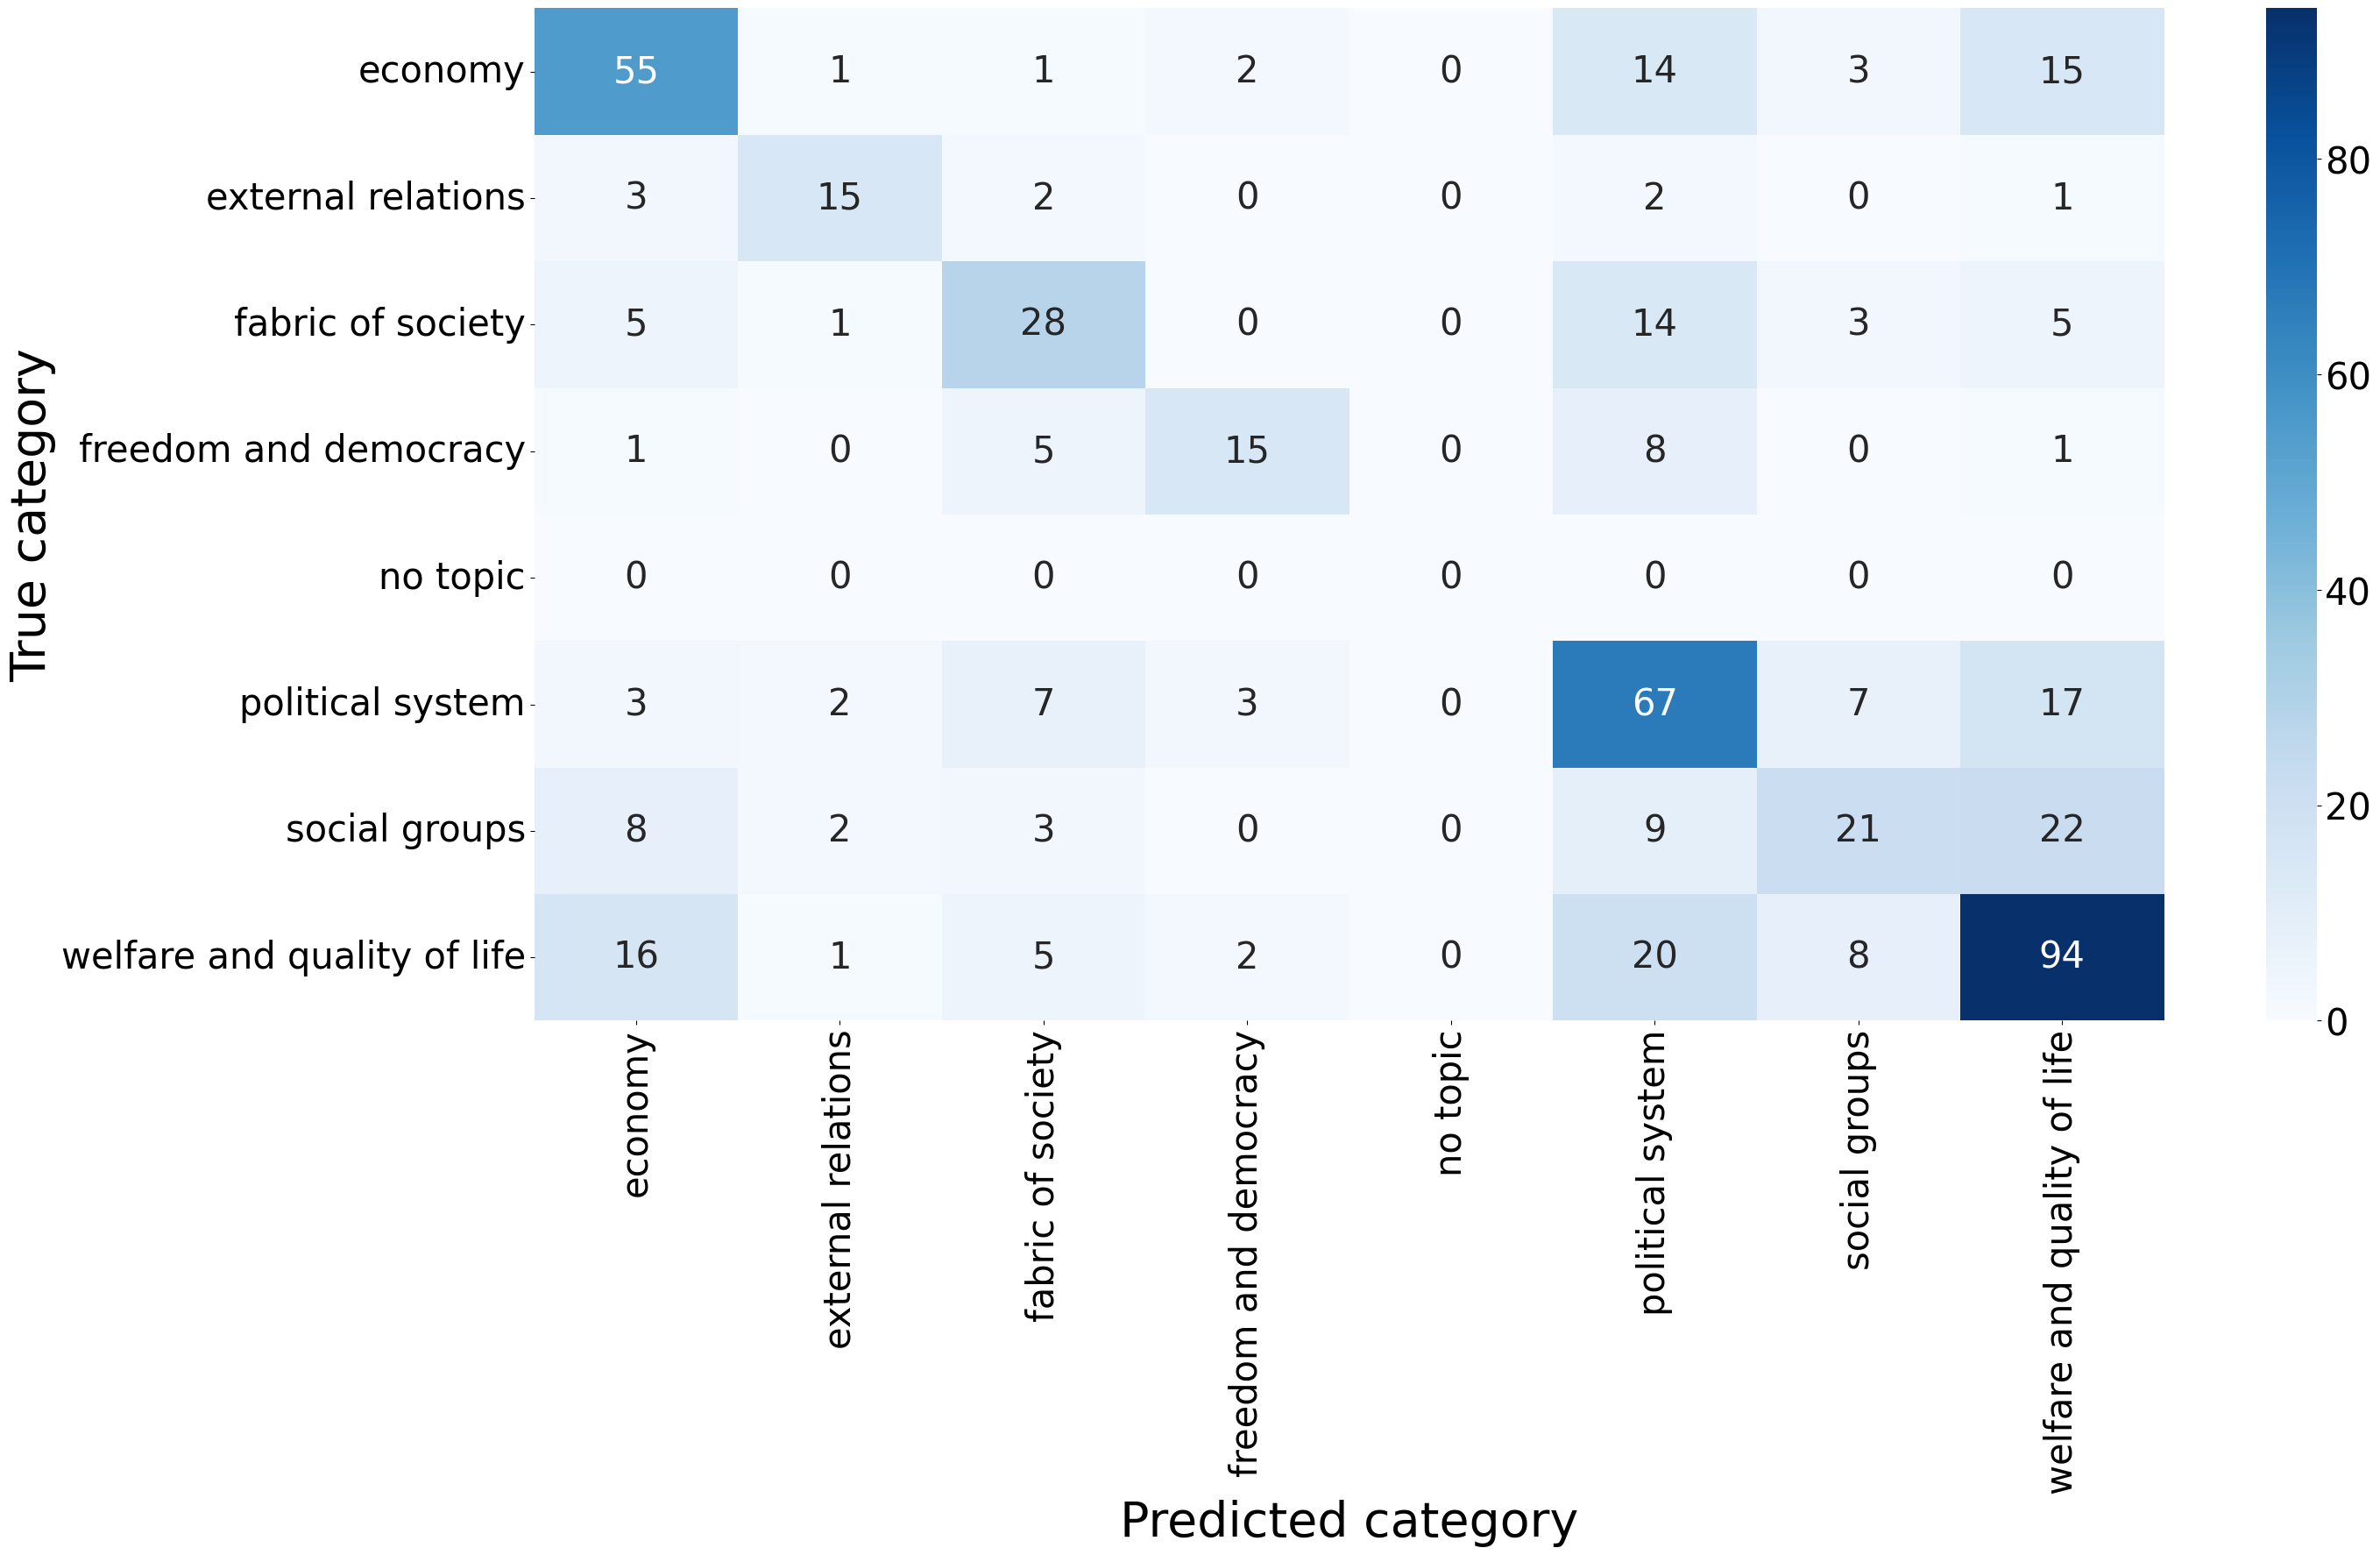

In [ ]:
# Confusion metric for different countries
for i in country.unique():
  print(i)
  print(len(Y_test_classes[country_test == i]))
  classification_report_per_country_test_set = evaluation_per_category(Y_test_classes[country_test == i], np.array(Y_pred_testing)[country_test == i], data_description = i+'_random_test_split', path_results = path_results, figsize=(30,15))

# Packages

In [ ]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

transformers==4.28.1
pandas==1.5.3
numpy==1.22.4
seaborn==0.12.2


In [ ]:
!pip list -v

Package                       Version              Location                               Installer
----------------------------- -------------------- -------------------------------------- ---------
absl-py                       1.4.0                /usr/local/lib/python3.9/dist-packages pip
aiohttp                       3.8.4                /usr/local/lib/python3.9/dist-packages pip
aiosignal                     1.3.1                /usr/local/lib/python3.9/dist-packages pip
alabaster                     0.7.13               /usr/local/lib/python3.9/dist-packages pip
albumentations                1.2.1                /usr/local/lib/python3.9/dist-packages pip
altair                        4.2.2                /usr/local/lib/python3.9/dist-packages pip
anyio                         3.6.2                /usr/local/lib/python3.9/dist-packages pip
appdirs                       1.4.4                /usr/local/lib/python3.9/dist-packages pip
argon2-cffi                   21.3.0            